In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns

In [ ]:
data = pd.read_csv('train.csv')
print(data.head())

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731

Removendo colunas inúteis

In [ ]:
data = data.drop(['id', 'vendor_id', 'dropoff_datetime', 'passenger_count', 'store_and_fwd_flag'], axis=1)

Transformando as cordenadas (latitude e longitude) em distâncias

In [ ]:
R = 6371000
lat1 = np.radians(data['pickup_latitude'])
lon1 = np.radians(data['pickup_longitude'])
lat2 = np.radians(data['dropoff_latitude'])
lon2 = np.radians(data['dropoff_longitude'])
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
data['distancia'] = R * c

Removendo Outliers

In [ ]:
#mean = np.mean(data['distancia']/data['trip_duration'])
#std = np.std(data['distancia']/data['trip_duration'])
#data = data[(((data['distancia']/data['trip_duration']) < (mean + 3 * std)) & (data['distancia']/data['trip_duration']) > (mean - 3 * std))]

Escalonando os dados de distância

In [ ]:
scaler = MinMaxScaler()
data['distancia'] = scaler.fit_transform(data['distancia'].values.reshape(-1, 1))

Dividindo os dados em treino e teste

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[['distancia']], data['trip_duration'], test_size=0.2, random_state=42, shuffle=True)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

Treinando algoritmo SGDRegression

In [ ]:
max_iters = [500, 1000, 2000]
tolerances = [1e-3, 1e-4, 1e-5]
melhores_param ={}
melhor_mse = np.inf
for max_iter in max_iters:
  for tol in tolerances:
    mse_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for trainindex, testindex in kf.split(X_train):
      model = SGDRegressor(max_iter=max_iter, tol=tol, random_state=42)
      model.fit(X_train.loc[trainindex], y_train.loc[trainindex])
      y_pred = model.predict(X_train.loc[testindex])
      mse_scores.append(mean_squared_error(y_train.loc[testindex], y_pred))
    mean_mse = np.mean(mse_scores)
    if mean_mse < melhor_mse:
      melhor_mse = mean_mse
      melhores_param = {'max_iter': max_iter, 'tol': tol}
model = SGDRegressor(max_iter=melhores_param['max_iter'], tol=melhores_param['tol'], random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Metricas para avaliação do SGDRegression

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print('Erro quadratico médio: ',round(mse, 2))
print('Erro médio: ',round(mean_absolute_error(y_test, y_pred), 2))
print('Erro médio com pesos: ', round(np.sqrt(mse), 2))
print('Coeficiente de determinação: ', round(r2_score(y_test, y_pred), 5))

Erro quadratico médio:  10548432.32
Erro médio:  607.63
Erro médio com pesos:  3247.84
Coeficiente de determinação:  0.0041


Gráficos

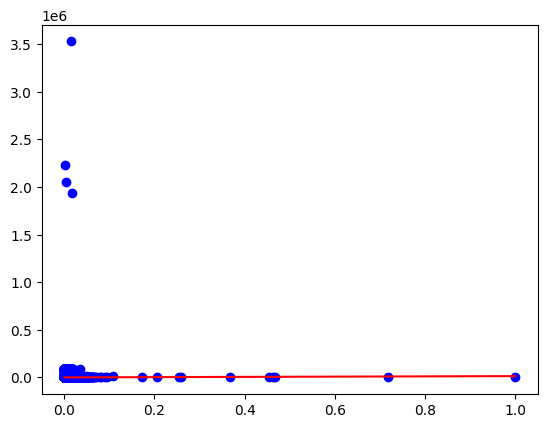

In [ ]:
coeficientes = model.coef_
intercepto = model.intercept_
x = np.linspace(data['distancia'].min(), data['distancia'].max(), 100)
y_pre = coeficientes * x + intercepto
plt.scatter(X_train, y_train, color='blue', label='Dados de treinamento')
plt.plot(x, y_pre, color='red', label='Reta ajustada')
plt.show()

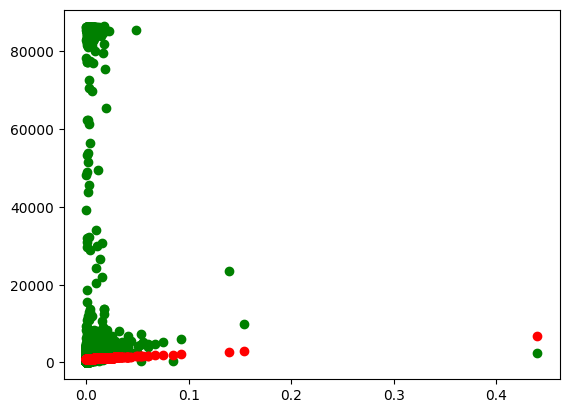

In [ ]:
plt.scatter(X_test, y_test, color='green', label='dados de teste')
plt.scatter(X_test, y_pred, color='red', label='previsão')
plt.show()

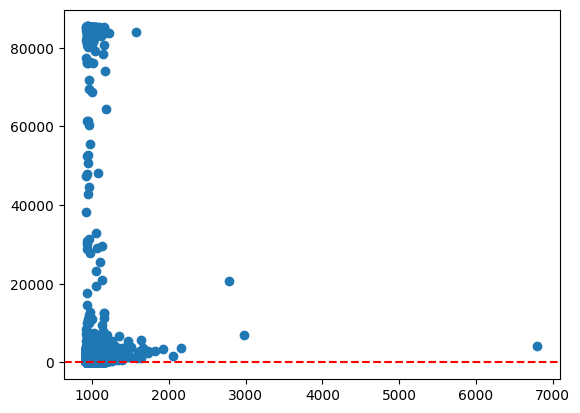

In [ ]:
erro = abs(y_test - y_pred)
plt.scatter(y_pred, erro)
plt.axhline(y=0, color='r', linestyle='--')

Treinando algoritmo DecisionTreeRegressor

In [ ]:
features = data[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
X_train, X_test, y_train, y_test = train_test_split(features, data['trip_duration'], test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

In [ ]:
max_depths = [3, 5, 7, 9]
min_samples_splits = [2, 5, 10]
min_samples_leafs = [1, 2, 5, 10]
melhores_param ={}
melhor_mse = np.inf
for max_depth in max_depths:
  for min_samples_split in min_samples_splits:
    for min_samples_leaf in min_samples_leafs:
      mse_scores = []
      kf = KFold(n_splits=5, shuffle=True, random_state=42)
      for trainindex, testindex in kf.split(X_train):
        model = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
        model.fit(X_train.loc[trainindex], y_train.loc[trainindex])
        y_pred = model.predict(X_train.loc[testindex])
        mse_scores.append(mean_squared_error(y_train.loc[testindex], y_pred))
      mean_mse = np.mean(mse_scores)
      if mean_mse < melhor_mse:
        melhor_mse = mean_mse
        melhores_param = {'max_depth': max_depth, 'min_samples_split':min_samples_split, 'min_samples_leaf':min_samples_leaf}
model = DecisionTreeRegressor(max_depth=melhores_param['max_depth'], min_samples_split=melhores_param['min_samples_split'], min_samples_leaf=melhores_param['min_samples_leaf'], random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Métricas

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print('Erro quadratico médio: ',round(mse, 2))
print('Erro médio: ',round(mean_absolute_error(y_test, y_pred), 2))
print('Erro médio com pesos: ', round(np.sqrt(mse), 2))
print('Coeficiente de determinação: ', round(r2_score(y_test, y_pred), 5))

Erro quadratico médio:  10427824.0
Erro médio:  541.86
Erro médio com pesos:  3229.21
Coeficiente de determinação:  0.01549


Gráficos

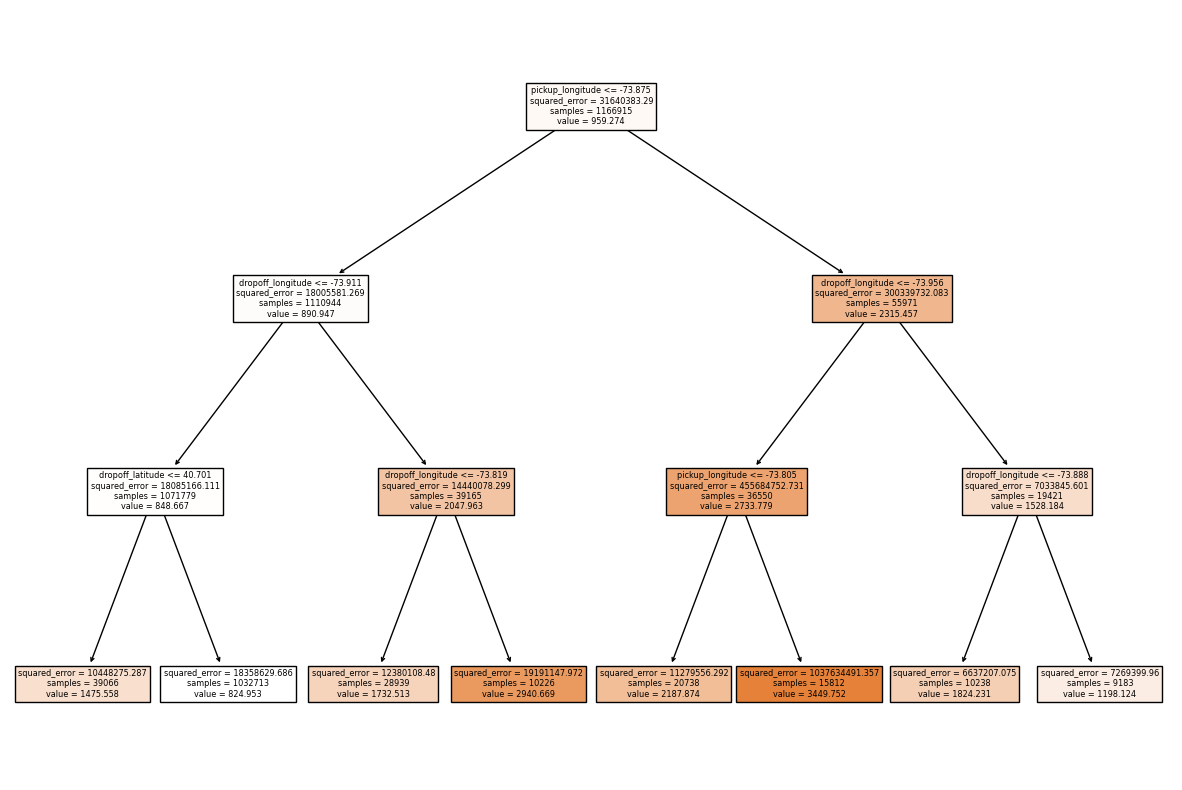

In [ ]:
plt.figure(figsize=(15, 10))
plot_tree(model, feature_names=features.columns, filled=True)
plt.show()

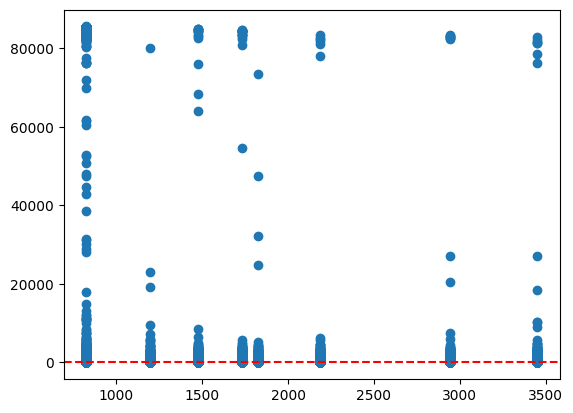

In [ ]:
erro = np.abs(np.squeeze(y_test) - np.squeeze(y_pred))
plt.scatter(y_pred, erro)
plt.axhline(y=0, color='r', linestyle='--')

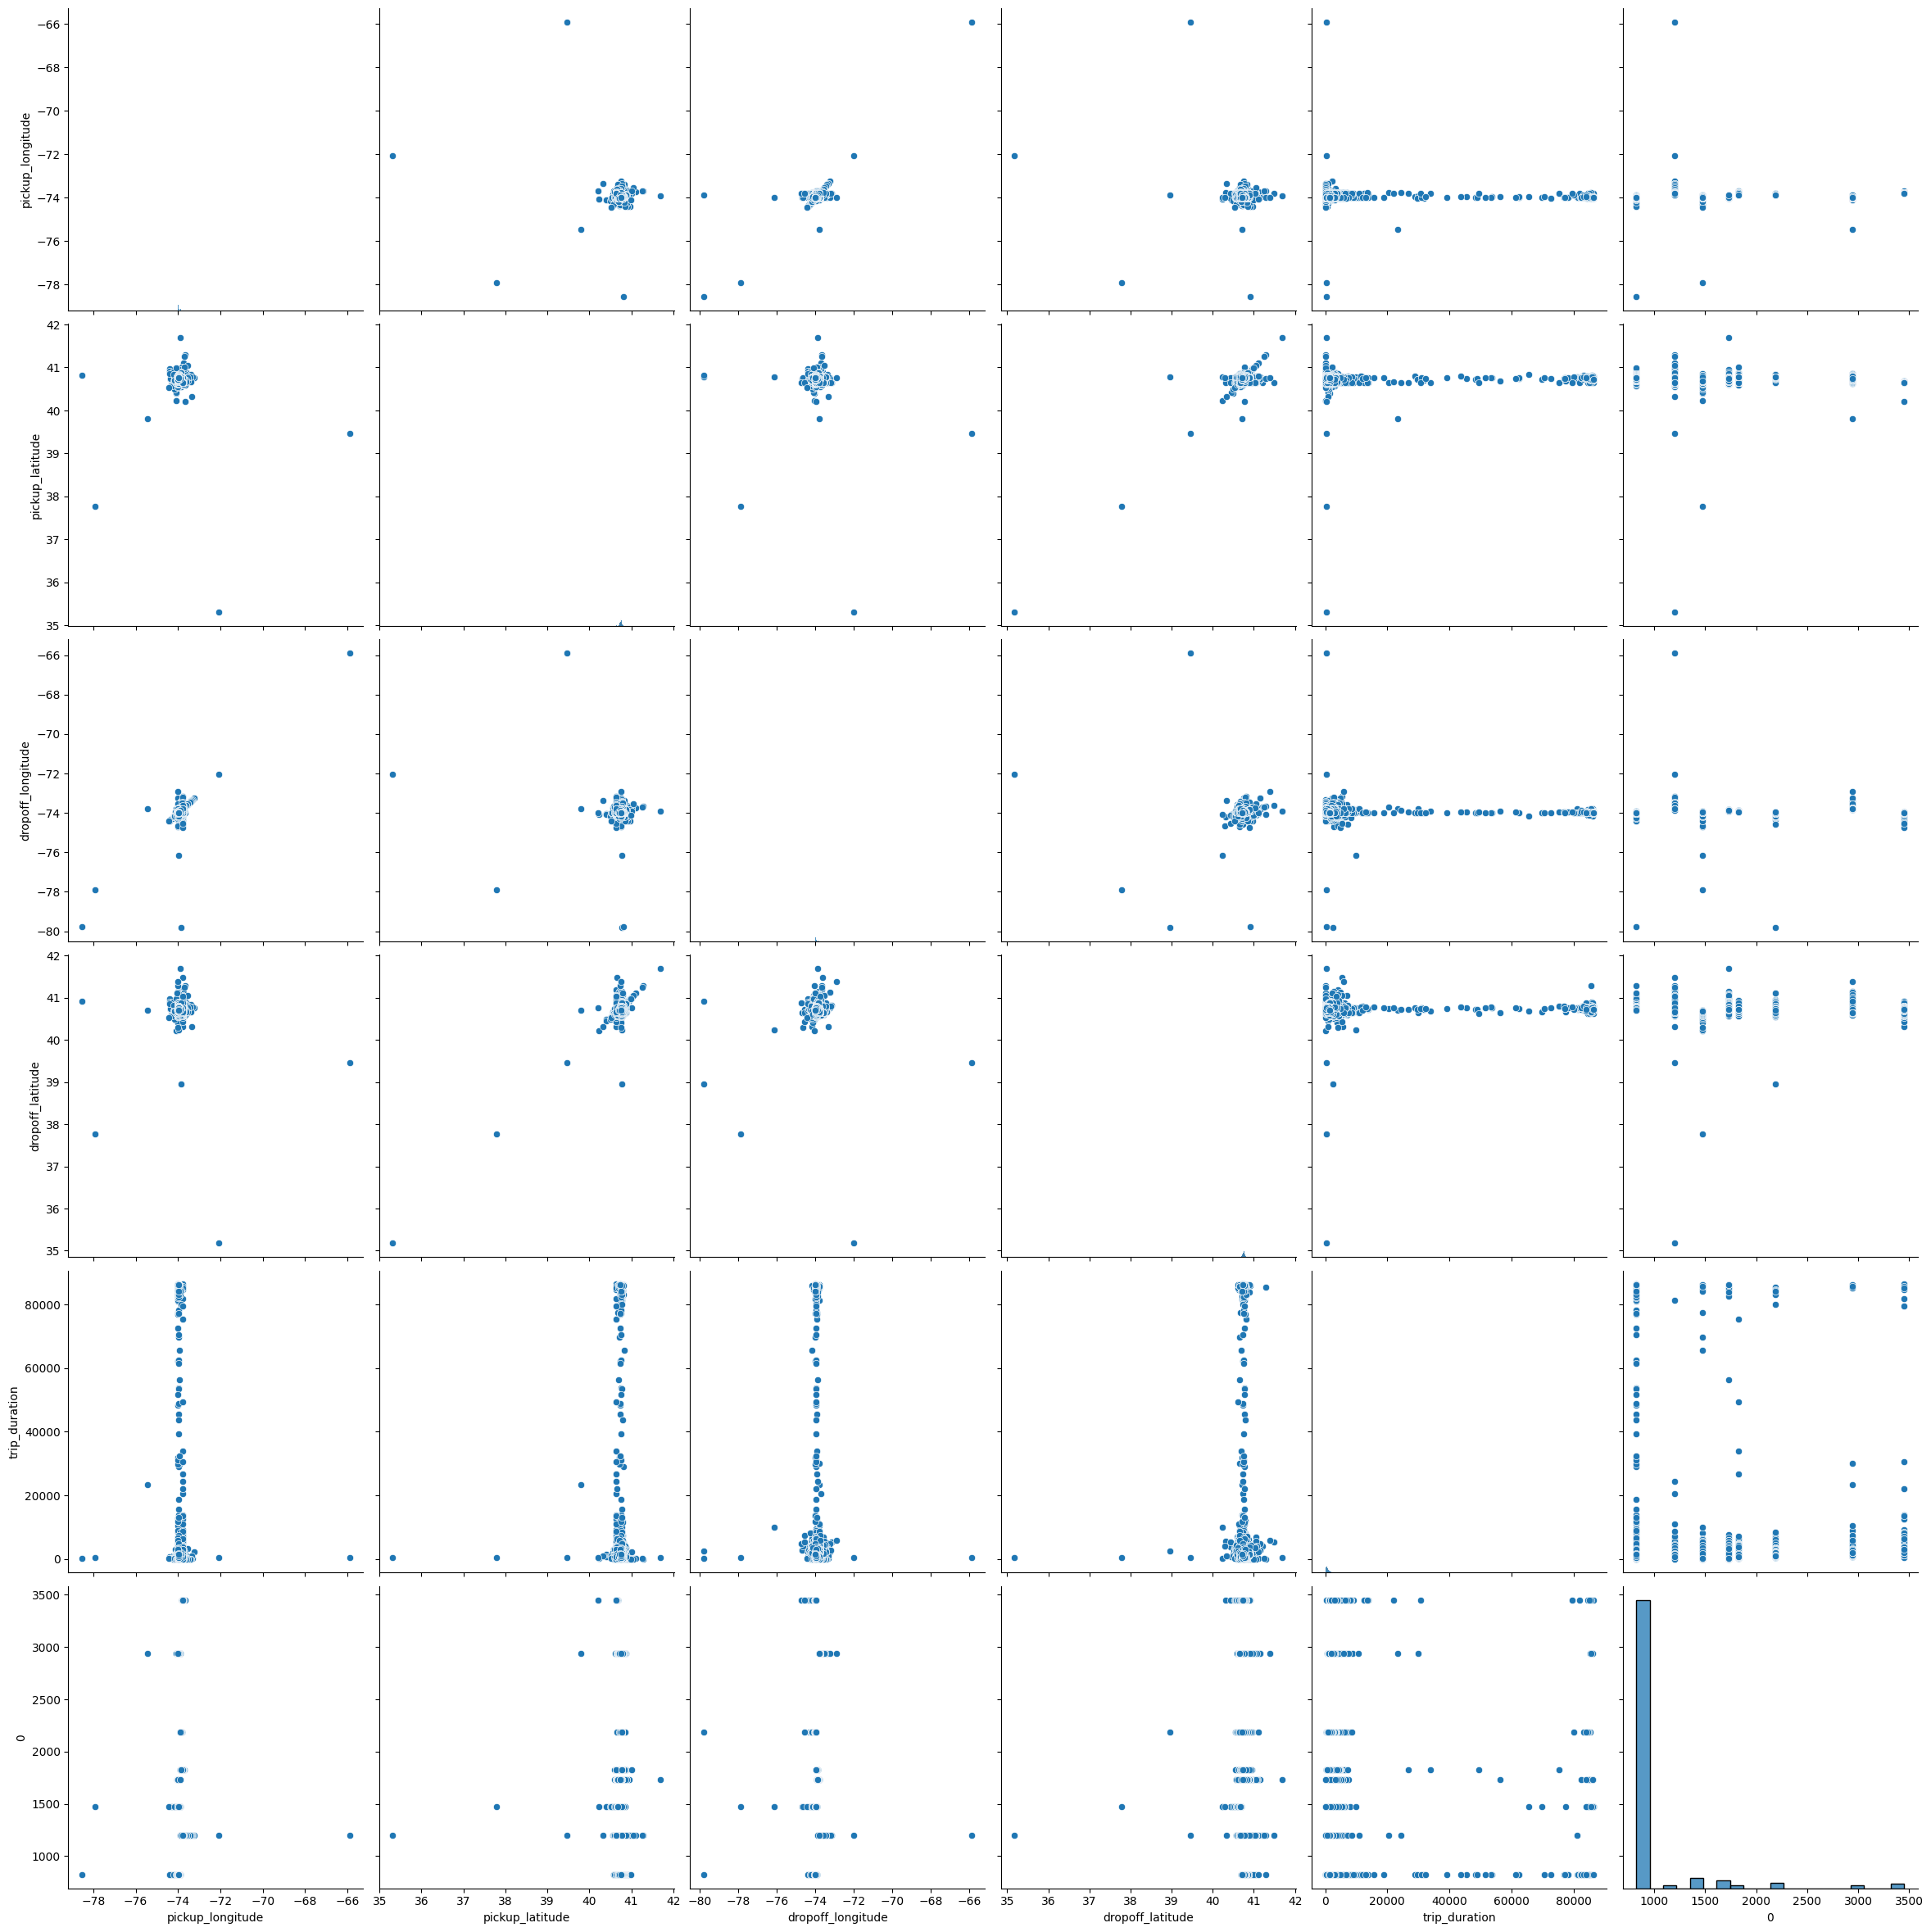

In [ ]:
pPlotar = pd.concat([X_test, y_test, pd.Series(y_pred)], axis=1)
sns.pairplot(pPlotar, kind='scatter', height=4)
plt.show()

Treinando algoritmo Support Vector Regression

In [ ]:
scaler2 = MinMaxScaler()
features = scaler2.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features, data['trip_duration'], test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train).reset_index(drop=True)
X_test = pd.DataFrame(X_test).reset_index(drop=True)
y_train = pd.DataFrame(y_train).reset_index(drop=True)
y_test = pd.DataFrame(y_test).reset_index(drop=True)

In [ ]:
model = SVR(kernel='poly', C=0.1, epsilon=0.1)
model.fit(X_train, y_train.values.ravel())

In [ ]:
kernels = ['rbf', 'poly', 'sigmoid']
Cs = [0.1, 1, 10]
epsilons = [0.01, 0.1, 0.5, 1]
melhores_param = {}
melhor_mse = np.inf
for kernel in kernels:
    for C in Cs:
        for epsilon in epsilons:
            mse_scores = []
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            for trainindex, testindex in kf.split(X_train):
                model = SVR(kernel=kernel, C=C, epsilon=epsilon)
                model.fit(X_train.loc[trainindex], y_train.loc[trainindex].values.ravel())
                y_pred = model.predict(X_train.loc[testindex])
                mse_scores.append(mean_squared_error(y_train.loc[testindex].values.ravel(), y_pred))
            mean_mse = np.mean(mse_scores)
            if mean_mse < melhor_mse:
                melhor_mse = mean_mse
                melhores_param = {'kernel': kernel, 'C': C, 'epsilon': epsilon}
model = SVR(kernel=melhores_param['kernel'], C=melhores_param['C'], epsilon=melhores_param['epsilon'])
model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

Métricas

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print('Erro quadratico médio: ',mse)
print('Erro médio: ',round(mean_absolute_error(y_test, y_pred), 5))
print('Erro médio com pesos: ', round(np.sqrt(mse), 5))
print('Coeficiente de determinação: ', round(r2_score(y_test, y_pred), 5))

Gráficos

In [ ]:
x = np.linspace(min(X_train), max(X_train), 100)
y = np.linspace(min(y_train), max(y_train), 100)
X, Y = np.meshgrid(x, y)
grid_points = np.c_[X.ravel(), Y.ravel()]
predictions = model.predict(grid_points)
plt.scatter(X_train, y_train, color='blue', label='Dados de treinamento')
plt.scatter(X_test, y_test, color='red', label='Dados de teste')
plt.contour(X, Y, predictions.reshape(X.shape), levels=[0], colors='black', linestyles='--', linewidths=2)
plt.show()

In [ ]:
erro = abs(y_test - y_pred)
plt.scatter(y_pred, erro)
plt.axhline(y=0, color='r', linestyle='--')